# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Установки библиотек

In [114]:
!pip install optuna
!pip install lightgbm
!pip install xgboost
!pip install catboost
!pip install category_encoders

### Импорты библиотек

In [115]:
# Built-in libraries
import warnings
from datetime import datetime

# Data manipulation libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning: helpers
from sklearn.model_selection import train_test_split

# Machine Learning: data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from category_encoders import MEstimateEncoder

# Machine Learning: models
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb

# Machine Learning: metrics
from sklearn.metrics import mean_squared_error

# Optimization library
import optuna
from optuna.study import create_study

# Display settings
%matplotlib inline
pd.set_option('display.max_columns', 999)

# Ignoring warnings
warnings.filterwarnings("ignore")


### Импорт данных


In [116]:
try:
    df = pd.read_csv('autos.csv')
except:
    try:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
    except:
        df = pd.read_csv('/datasets/autos.csv')

### Создание констан


In [117]:
RANDOM_STATE=12345

### Оценка датасета


In [118]:
row_count = df.shape[0]
row_count

354369

In [119]:
for dtype in ['float','int','object']:
    selected_dtype = df.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

df.info(memory_usage='deep')

Average memory usage for float columns: 0.00 MB
Average memory usage for int columns: 2.37 MB
Average memory usage for object columns: 19.81 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   3

In [120]:
def get_dataset_short_info(df: pd.DataFrame) -> pd.DataFrame:

    """
    Функция для отображения короткой информации по датасету. Аналог функции df.info()

    Args:
        df (pd.DataFrame): Датафрейм с исходным датасетом

    Returns:
        pd.DataFrame: Возвращает датафрейм с описанием данных
    """

    shape = df.shape[0]
    columns = ['column', 'count_values','unique_values', '% unique', 'missing', '% missing','dtype', 'var_variance']
    rows = []
    for col in df.columns:
        rows.extend([[
            col, # название столбца
            df[col].count(), # кол-во НЕ пустых значений
            df[col].nunique(), # кол-во уникальных значений
            str(round(df[col].nunique() * 100 / df[col].count(), 2))+'%', # доля уникальных значений
            df[col].isna().sum(), # кол-во пропущенных значений
            round(df[col].isna().sum() / shape * 100, 2), # доля пропущенных значений
            str(df[col].dtype), # тип данных
            df[col].value_counts().count()]]) # вариативность значений атрибута
    info = pd.DataFrame(data=rows, columns=columns)
    info = info.sort_values(by=['% missing', 'missing'], ascending=False).round(4)
    info['% missing'] = info['% missing'].astype(str) + '%'
    return info


get_dataset_short_info(df)

,column,count_values,unique_values,% unique,missing,% missing,dtype,var_variance
11,Repaired,283215,2,0.0%,71154,20.08%,object,2
2,VehicleType,316879,8,0.0%,37490,10.58%,object,8
9,FuelType,321474,7,0.0%,32895,9.28%,object,7
4,Gearbox,334536,2,0.0%,19833,5.6%,object,2
6,Model,334664,250,0.07%,19705,5.56%,object,250
0,DateCrawled,354369,271174,76.52%,0,0.0%,object,271174
1,Price,354369,3731,1.05%,0,0.0%,int64,3731
3,RegistrationYear,354369,151,0.04%,0,0.0%,int64,151
5,Power,354369,712,0.2%,0,0.0%,int64,712
7,Kilometer,354369,13,0.0%,0,0.0%,int64,13


Согласно предоставленной таблице, мы можем сделать следующие выводы:

1. **Пропущенные значения**: Колонки Repaired, VehicleType, FuelType, Gearbox, и Model имеют пропущенные значения, причем колонка Repaired имеет наибольшее количество пропусков - 20% данных. Это требует внимания при обработке данных, так как пропуски могут повлиять на качество предсказания модели.

2. **Категориальные признаки**: Колонки Repaired, VehicleType, FuelType, Gearbox, Model, и Brand являются категориальными переменными.

3. **Непрерывные / числовые признаки**: Price, RegistrationYear, Power, Kilometer, RegistrationMonth, NumberOfPictures, и PostalCode являются числовыми переменными.
Уникальность: Колонки DateCrawled, Price, PostalCode, и LastSeen имеют большое количество уникальных значений.
**В частности, NumberOfPictures имеет всего одно уникальное значение, что делает его бесполезным для модели.**

4. **Временные признаки**: DateCrawled, RegistrationYear, RegistrationMonth, DateCreated, и LastSeen - это временные признаки. Они могут потребовать дополнительной предварительной обработки, в зависимости от того, как они будут использоваться в модели.


In [121]:
missing_rows = df[df[['Repaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model']].isnull().all(axis=1)].shape[0]
print(f"Пропущено во всех 5 признаках: {missing_rows}")


Пропущено во всех 5 признаках: 2237


In [122]:
missing_rows = df[df[['Repaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model']].isnull().sum(axis=1) >= 3].shape[0]
print(f"Пропущено хотя бы в 3 признаках: {missing_rows}")


Пропущено хотя бы в 3 признаках: 18028


Эти 5% данных можно удалить для улучшения качества данных, даже с учетом наших заглушек в дальнейшем.

In [123]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


- **Price**: Средняя цена автомобиля составляет около 4416 единиц, при этом минимальная цена равна 0 (что может быть ошибкой), а максимальная - 20000. Это целевая переменная для нашей задачи предсказания цены автомобиля, поэтому основное внимание следует уделить этому столбцу. Можно рассмотреть возможность удаления строк с аномально низкой или высокой ценой.

- **RegistrationYear**: Минимальный год регистрации - 1000 (что очевидно является ошибкой, так как автомобили не существовали в том году), а максимальный год - 9999 (что также является ошибкой, так как это год далеко в будущем). Это указывает на наличие некорректных данных в этом столбце, которые необходимо исправить.
- **Power**: Средняя мощность автомобиля составляет около 110, при этом минимальное значение - 0 и  максимальное - 20000 могут быть ошибками.
- **Kilometer**: Максимальное и 75% квартиль значения совпадают, что указывает на возможное наличие выбросов в данных.
- **NumberOfPictures**: Все значения равны 0, этот столбец не несет никакой информации, и его следует удалить.
- **PostalCode**: Значения в этом столбце варьируются от 1067 до 99998. В зависимости от того, насколько значимым является этот признак для модели, его можно оставить или исключить.

Помимо вышеупомянутого, с точки зрения машинного обучения, также стоит проверить, нет ли сильной корреляции между признаками, и в случае необходимости устранить ее.

Важно также провести анализ выбросов, чтобы убедиться, что модель не будет переобучаться на аномальных данных. Например, автомобили с аномально высокой мощностью или стоимостью могут искажать результаты.

Наконец, нам следует также проанализировать распределение целевого признака (Price). Если оно сильно искажено, это может влиять на производительность некоторых моделей машинного обучения, и нам может потребоваться преобразовать данные, чтобы улучшить производительность модели.

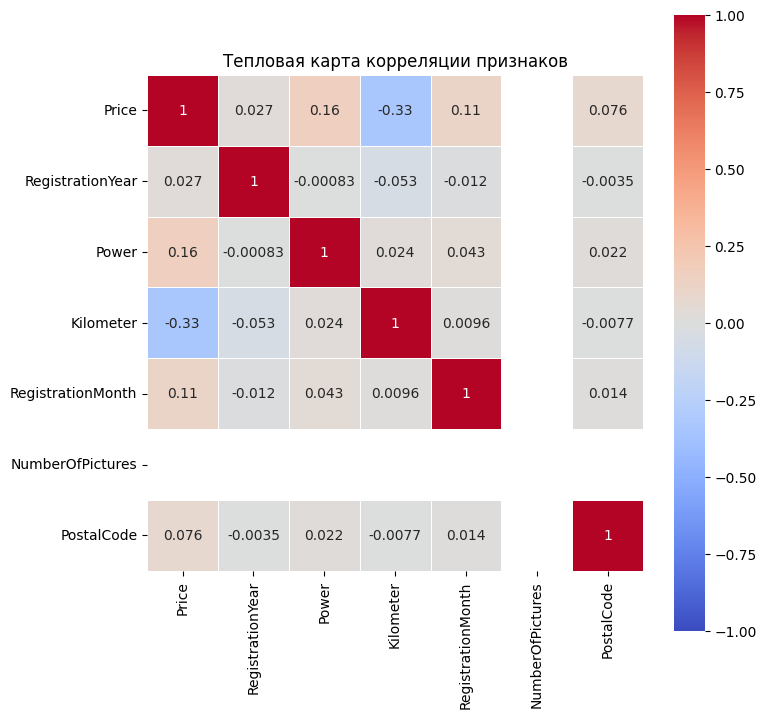

In [124]:
correlation_matrix = df.corr()

plt.figure(figsize=(8, 8))

sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
)


plt.title("Тепловая карта корреляции признаков")
plt.show()

- **Price (Цена)**: Наиболее сильно коррелирует с признаком Power (Мощность). Это логично, поскольку мощные автомобили обычно стоят дороже. Также цена отрицательно коррелирует с признаком **Kilometer (Пробег)**, что также вполне ожидаемо, так как автомобили с большим пробегом обычно стоят дешевле.
- **RegistrationYear (Год регистрации)**: Этот признак практически не коррелирует ни с одним из остальных признаков, включая целевой признак Price. Это может указывать на то, что год регистрации автомобиля не имеет большого влияния на его стоимость.
- **Power (Мощность)**: Как уже было отмечено, этот признак наиболее сильно коррелирует с целевым признаком Price. Он также слабо коррелирует с признаком RegistrationMonth (Месяц регистрации), хотя эта корреляция, скорее всего, не имеет практического значения.
- **RegistrationMonth (Месяц регистрации)** и **ostalCode (Почтовый индекс)**: Эти признаки слабо коррелируют с целевым признаком Price, что может указывать на то, что они не имеют большого влияния на стоимость автомобиля.


In [125]:
df.duplicated().sum()

4

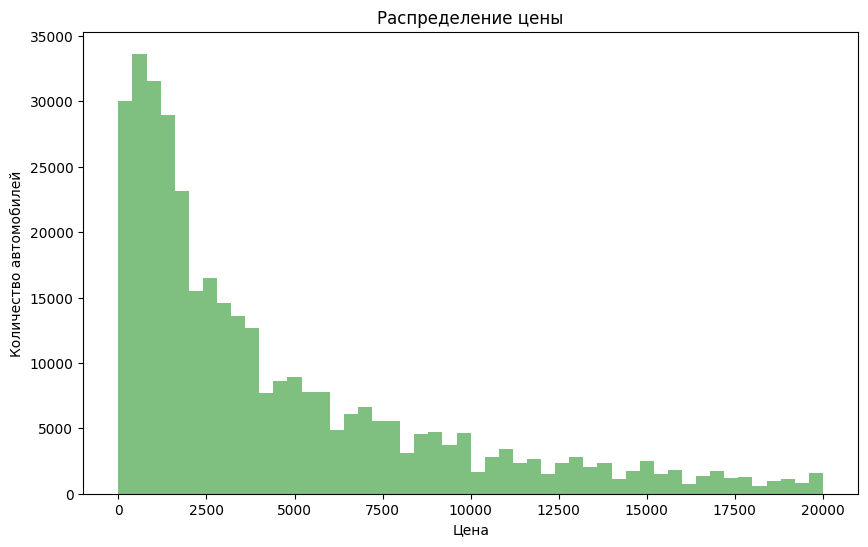

In [126]:
plt.figure(figsize=(10, 6))
plt.hist(df['Price'], bins=50, alpha=0.5, color='g')
plt.title('Распределение цены')
plt.xlabel('Цена')
plt.ylabel('Количество автомобилей')
plt.show()

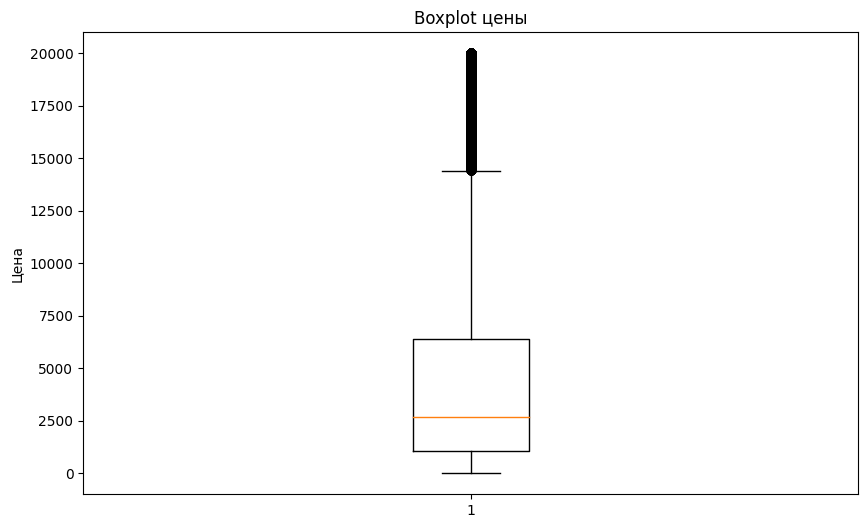

In [127]:
plt.figure(figsize=(10, 6))
plt.boxplot(df['Price'])
plt.title('Boxplot цены')
plt.ylabel('Цена')
plt.show()

Наша целевая переменная имеет экспоненциальное распределение и в основном в нашем наборе данных преобладают достаточно низкие значения, в том числе очень низкие. Необходимо убрать слишком низкие значения (меньше 500), т.к. данные объявления несут ложную оценку реальной стоимости автомобиля, в следствии чего, наш прогноз по новым объявлениям может быть некорректным.

In [128]:
df[['Repaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model']].isnull().corr()

,Repaired,VehicleType,FuelType,Gearbox,Model
Repaired,1.000000,0.298733,0.242168,0.269865,0.156695
VehicleType,0.298733,1.000000,0.436779,0.314202,0.189908
FuelType,0.242168,0.436779,1.000000,0.299483,0.226342
Gearbox,0.269865,0.314202,0.299483,1.000000,0.162229
Model,0.156695,0.189908,0.226342,0.162229,1.000000



- FuelType и VehicleType имеют наибольшую корреляцию 0.44 среди всех пар, что указывает на достаточно сильную связь между пропусками в этих столбцах.
- Пропуски в Gearbox и Model имеют наименьшую корреляцию, что указывает на отсутствие сильной связи между пропусками в этих столбцах.

## Предобработка данных


In [129]:
df = df.drop('NumberOfPictures', axis=1)

In [130]:
df = df.drop_duplicates()

In [131]:
df = df[df[['Repaired', 'VehicleType', 'FuelType', 'Gearbox', 'Model']].isnull().sum(axis=1) < 3]

In [132]:
# оценим признак Repaired
df['Repaired'].value_counts(dropna=False, normalize=True)

no     0.730645
NaN    0.163836
yes    0.105519
Name: Repaired, dtype: float64

По логике, если нет данных о ремонте, то машина в ремонте не была, но лучше все таки поставить тут заглушку, чем установить значение no


In [133]:
df['Repaired'] = df['Repaired'].fillna('unknown')

In [134]:
# оценим признак VehicleType
df['VehicleType'].value_counts(dropna=False, normalize=True)

sedan          0.270175
small          0.235056
wagon          0.192313
bus            0.084945
NaN            0.065773
convertible    0.059494
coupe          0.047551
suv            0.035369
other          0.009324
Name: VehicleType, dtype: float64

Нет скрытых дубликатов в категориях признака, поэтому заменим пропуски заглушкой


In [135]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')

In [136]:
#оценим признак FuelType
df['FuelType'].value_counts(dropna=False, normalize=True)

petrol      0.635327
gasoline    0.290818
NaN         0.055123
lpg         0.015621
cng         0.001668
hybrid      0.000684
other       0.000502
electric    0.000256
Name: FuelType, dtype: float64

petrol и gasoline - имеют один смысл, заменим одно на другое

In [137]:
df.loc[df['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'
#заполним пропуски самым частым
df['FuelType']  = df['FuelType'].fillna('petrol')

In [138]:
#проверим Gearbox
df['Gearbox'].value_counts(dropna=False, normalize=True)

manual    0.779834
auto      0.193544
NaN       0.026622
Name: Gearbox, dtype: float64

In [139]:
#заполним пропуски самым частым
df['Gearbox'] = df['Gearbox'].fillna('manual')

In [140]:
#заполним пропуски в моделях заглушкой, так как разумно заполнить тут проблематично
df['Model'] = df['Model'].fillna('unknown')

**Посмотрели на объем пропусков. Мы заполнили пропуски вручную там, где это требовалось. Убрали неявные и явные дубликаты.**

Разберемся теперь с аномалиями.

In [141]:
df['Price'].describe()

count    336337.000000
mean       4553.640272
std        4543.565743
min           0.000000
25%        1199.000000
50%        2899.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

In [142]:
len(df.loc[df['Price'] < 300])/len(df)

0.05300041327597023

In [143]:
df = df.loc[df['Price'] >= 300]

Удалим строки, в которых машины дешевле 300 евро, даже для того времени это слишком низкая цена за бу мащину, а выбросы сверху оставим, так как бывают очень дорогие машины

In [144]:
#уберем все что выше 2016 (так как данные на этот год) и ниже 1910, эти данные сложно будет корректно исправить
df = df[df['RegistrationYear'] < 2016]
df = df[df['RegistrationYear'] > 1910]

In [145]:
# удалим строки с мощностью двигателя меньше 30 и больше 1500 лс
df = df.query('Power > 30 and Power < 1500')

In [146]:
df['Kilometer'].describe()

count    279769.000000
mean     128099.557135
std       36602.290856
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

в данных заметен верхний предел, так что данные не совсем точно отражают пробег.

In [147]:
get_dataset_short_info(df)

,column,count_values,unique_values,% unique,missing,% missing,dtype,var_variance
0,DateCrawled,279769,226543,80.98%,0,0.0%,object,226543
1,Price,279769,3421,1.22%,0,0.0%,int64,3421
2,VehicleType,279769,9,0.0%,0,0.0%,object,9
3,RegistrationYear,279769,78,0.03%,0,0.0%,int64,78
4,Gearbox,279769,2,0.0%,0,0.0%,object,2
5,Power,279769,495,0.18%,0,0.0%,int64,495
6,Model,279769,250,0.09%,0,0.0%,object,250
7,Kilometer,279769,13,0.0%,0,0.0%,int64,13
8,RegistrationMonth,279769,13,0.0%,0,0.0%,int64,13
9,FuelType,279769,6,0.0%,0,0.0%,object,6


Данных убрали достаточно, но качество данных важнее их количества.

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

## Обработка данных

Разделим данные на обучающиеся и тестовые, при этом уберем из массива признаки, которые не влияют на модель.


In [148]:
features = df.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode'], axis=1)
target = df['Price']


In [149]:
# Разбиваем на тренировочную и тестовую выборки
X_temp, X_test, y_temp, y_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)

# Дальше разбиваем тренировочную выборку на обучающую и валидационную
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE)

# Создание отдельных наборов данных для CatBoost
X_train_catboost = X_train.copy()
X_val_catboost = X_val.copy()
X_test_catboost = X_test.copy()


In [150]:
print("Размер обучающей выборки (X_train):", X_train.shape)
print("Размер тестовой выборки (X_test):", X_test.shape)
print("Размер валидационной выборки (X_val):", X_val.shape)
print("Размер целевого признака для обучающей выборки (y_train):", y_train.shape)
print("Размер целевого признака для тестовой выборки (y_test):", y_test.shape)
print("Размер целевого признака для валидационной выборки (y_val):", y_val.shape)

Размер обучающей выборки (X_train): (167861, 10)
Размер тестовой выборки (X_test): (55954, 10)
Размер валидационной выборки (X_val): (55954, 10)
Размер целевого признака для обучающей выборки (y_train): (167861,)
Размер целевого признака для тестовой выборки (y_test): (55954,)
Размер целевого признака для валидационной выборки (y_val): (55954,)


Построим пайплайн обработки данных, разделим данные и категориальные и количественные и для каждого типа сделаем свою обработку данных:
- для категориальных сделаем импутацию на основе самых частых значений, а затем сделаем кодирование методом OHE
- для количественных сделаем масштабирование признаков

In [151]:
# Делим столбцы на категориальные и числовые
cat_columns = X_train.select_dtypes(include='object').columns.tolist()
num_columns = X_train.select_dtypes(exclude='object').columns.tolist()

In [152]:
# Заполнение пропущенных значений
cat_imputer = SimpleImputer(strategy='most_frequent')

X_train_cat_impute = cat_imputer.fit_transform(X_train[cat_columns])
X_val_cat_impute = cat_imputer.transform(X_val[cat_columns])
X_test_cat_impute = cat_imputer.transform(X_test[cat_columns])

X_train_cat_impute = pd.DataFrame(X_train_cat_impute, columns=cat_columns, index=X_train.index)
X_val_cat_impute = pd.DataFrame(X_val_cat_impute, columns=cat_columns, index=X_val.index)
X_test_cat_impute = pd.DataFrame(X_test_cat_impute, columns=cat_columns, index=X_test.index)

X_train[cat_columns] = X_train_cat_impute
X_val[cat_columns] = X_val_cat_impute
X_test[cat_columns] = X_test_cat_impute

X_train_catboost[cat_columns] = X_train_cat_impute
X_val_catboost[cat_columns] = X_val_cat_impute
X_test_catboost[cat_columns] = X_test_cat_impute

In [153]:
# Применение MEstimateEncoder
encoder_cols = ['Brand', 'Model']
encoder = MEstimateEncoder(cols=encoder_cols)

X_train_encoded = encoder.fit_transform(X_train[encoder_cols], y_train)
X_val_encoded = encoder.transform(X_val[encoder_cols])
X_test_encoded = encoder.transform(X_test[encoder_cols])

X_train = pd.concat([X_train.drop(encoder_cols, axis=1), X_train_encoded], axis=1)
X_val = pd.concat([X_val.drop(encoder_cols, axis=1), X_val_encoded], axis=1)
X_test = pd.concat([X_test.drop(encoder_cols, axis=1), X_test_encoded], axis=1)

X_train_catboost = pd.concat([X_train_catboost.drop(encoder_cols, axis=1), X_train_encoded], axis=1)
X_val_catboost = pd.concat([X_val_catboost.drop(encoder_cols, axis=1), X_val_encoded], axis=1)
X_test_catboost = pd.concat([X_test_catboost.drop(encoder_cols, axis=1), X_test_encoded], axis=1)

# Удаление 'Brand' и 'Model' из списка категориальных столбцов
cat_columns.remove('Brand')
cat_columns.remove('Model')

In [154]:
# Применение OneHotEncoder

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

X_train_ohe = ohe.fit_transform(X_train[cat_columns])
X_val_ohe = ohe.transform(X_val[cat_columns])
X_test_ohe = ohe.transform(X_test[cat_columns])

try:
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out(), index=X_train.index)
    X_val_ohe = pd.DataFrame(X_val_ohe, columns=ohe.get_feature_names_out(), index=X_val.index)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out(), index=X_test.index)
except:
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(), index=X_train.index)
    X_val_ohe = pd.DataFrame(X_val_ohe, columns=ohe.get_feature_names(), index=X_val.index)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names(), index=X_test.index)

X_train = pd.concat([X_train.drop(cat_columns, axis=1), X_train_ohe], axis=1)
X_val = pd.concat([X_val.drop(cat_columns, axis=1), X_val_ohe], axis=1)
X_test = pd.concat([X_test.drop(cat_columns, axis=1), X_test_ohe], axis=1)


In [155]:
# Применение StandardScaler
scaler = StandardScaler()

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_val[num_columns] = scaler.transform(X_val[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

# Применяем также StandardScaler к X_train_catboost, X_val_catboost и X_test_catboost
X_train_catboost[num_columns] = scaler.transform(X_train_catboost[num_columns])
X_val_catboost[num_columns] = scaler.transform(X_val_catboost[num_columns])
X_test_catboost[num_columns] = scaler.transform(X_test_catboost[num_columns])

## Обучение моделей

### Создание функция для базовых моделей

Создадим функцию и датафрейм, куда будет записывать результаты выполнения всех моделей + метрики по результатам выполнения

In [156]:
# Инициализация DataFrame для хранения результатов экспериментов
experiments = pd.DataFrame(columns=['Train RMSE', 'Validation RMSE', 'Test RMSE', 'Training time, sec', 'Predict on validation time, sec', 'Predict on test time, sec'])
experiments.index.name = 'Model'

In [157]:
def add_experiment(est, X_train_data, X_val_data, X_test_data, y_train_data, y_val_data, y_test_data, exp_name):
    model = est
    start_train = datetime.now()
    model.fit(X_train_data, y_train_data)
    end_train = datetime.now()
    delta_train = end_train - start_train
    predict_on_train = model.predict(X_train_data)
    start_val = datetime.now()
    predict_on_val = model.predict(X_val_data)
    end_val = datetime.now()
    delta_val = end_val - start_val
    start_test = datetime.now()
    predict_on_test = model.predict(X_test_data)
    end_test = datetime.now()
    delta_test = end_test - start_test
    rmse_on_train = np.round(((mean_squared_error(y_train_data, predict_on_train))**0.5), 1)
    rmse_on_val = np.round(((mean_squared_error(y_val_data, predict_on_val))**0.5), 1)
    rmse_on_test = np.round(((mean_squared_error(y_test_data, predict_on_test))**0.5), 1)
    experiments.loc[exp_name] = [rmse_on_train, rmse_on_val, rmse_on_test, delta_train.total_seconds(), delta_val.total_seconds(), delta_test.total_seconds()]


### Обучение базовых моделей

#### Linear Regression (Ridge)

In [158]:
lr = Ridge()

In [159]:
add_experiment(lr, X_train, X_val, X_test, y_train, y_val, y_test, 'LR')

#### CatBoost Regressor

In [160]:
catboost = CatBoostRegressor(verbose=100, cat_features=cat_columns)

# Вызываем функцию add_experiment с дополнительным параметром X_test и y_test
add_experiment(catboost, X_train_catboost, X_val_catboost, X_test_catboost, y_train, y_val, y_test, 'CatBoost with default parameters')


Learning rate set to 0.091986
0:	learn: 4336.7498151	total: 170ms	remaining: 2m 50s
100:	learn: 1722.7966732	total: 25.9s	remaining: 3m 50s
200:	learn: 1644.5700061	total: 41.6s	remaining: 2m 45s
300:	learn: 1606.3496573	total: 54.5s	remaining: 2m 6s
400:	learn: 1577.7995705	total: 1m 7s	remaining: 1m 41s
500:	learn: 1555.0096698	total: 1m 20s	remaining: 1m 20s
600:	learn: 1538.5772253	total: 1m 33s	remaining: 1m 2s
700:	learn: 1524.5607038	total: 1m 46s	remaining: 45.6s
800:	learn: 1512.4829521	total: 1m 59s	remaining: 29.7s
900:	learn: 1501.6765908	total: 2m 12s	remaining: 14.6s
999:	learn: 1491.1231473	total: 2m 25s	remaining: 0us


#### LightGBM

In [163]:
for c in cat_columns:
    X_train_catboost[c] = X_train_catboost[c].astype('category')
    X_val_catboost[c] = X_val_catboost[c].astype('category')
    X_test_catboost[c] = X_test_catboost[c].astype('category')

train_data = lgb.Dataset(X_train_catboost, label=y_train, categorical_feature=cat_columns)
val_data = lgb.Dataset(X_val_catboost, label=y_val, reference=train_data)

num_round = 1000
early_stopping_rounds = 100

param_grid = {'objective': 'regression', 'metric': 'root_mean_squared_error'}

start_train = datetime.now()

model = lgb.train(param_grid, train_data, num_round, valid_sets = [train_data, val_data],
                  verbose_eval=500, early_stopping_rounds=early_stopping_rounds)

end_train = datetime.now()
delta_train = end_train - start_train

start_train_predict = datetime.now()
predict_train = model.predict(X_train_catboost, num_iteration=model.best_iteration)
end_train_predict = datetime.now()

start_val_predict = datetime.now()
predict_val = model.predict(X_val_catboost, num_iteration=model.best_iteration)
end_val_predict = datetime.now()

start_test_predict = datetime.now()
predict_test = model.predict(X_test_catboost, num_iteration=model.best_iteration)
end_test_predict = datetime.now()

delta_train_predict = end_train_predict - start_train_predict
delta_val_predict = end_val_predict - start_val_predict
delta_test_predict = end_test_predict - start_test_predict

rmse_train = np.round((mean_squared_error(y_train, predict_train))**0.5, 1)
rmse_val = np.round((mean_squared_error(y_val, predict_val))**0.5, 1)
rmse_test = np.round((mean_squared_error(y_test, predict_test))**0.5, 1)

experiments.loc['LGBM'] = [rmse_train, rmse_val, rmse_test, delta_train.total_seconds(), delta_val_predict.total_seconds(), delta_test_predict.total_seconds()]


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.218899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 663
[LightGBM] [Info] Number of data points in the train set: 167861, number of used features: 10
[LightGBM] [Info] Start training from score 5048.847213
Training until validation scores don't improve for 100 rounds
[500]	training's rmse: 1411.54	valid_1's rmse: 1527.19
[1000]	training's rmse: 1316.85	valid_1's rmse: 1499.19
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 1316.85	valid_1's rmse: 1499.19


#### XGBoost

XGBoost не умеет напрямую работать с категориальными признаками, но мы уже преобразовали их с помощью OneHotEncoder и MEstimateEncoder, поэтому просто передадим преобразованные данные в модель.


In [165]:
xgbr = xgb.XGBRegressor(verbosity=0)

In [166]:
add_experiment(xgbr, X_train, X_val, X_test, y_train, y_val, y_test, 'XGB')

#### Dummy Regressor

DummyRegressor является простой моделью, которая не требует никаких особенностей в данных, так что мы просто передадим наши данные в модель.

In [168]:
dummy = DummyRegressor(strategy='median')

In [169]:
add_experiment(dummy, X_train, X_val, X_test, y_train, y_val, y_test, 'Dummy')


### Результаты экспериментов

In [170]:
experiments

,Train RMSE,Validation RMSE,Test RMSE,"Training time, sec","Predict on validation time, sec","Predict on test time, sec"
Model,,,,,,
LR,2782.4,2780.5,2786.1,0.071584,0.010233,0.035628
CatBoost with default parameters,1492.3,1562.4,1577.9,146.032359,0.162333,0.146253
LGBM,1316.9,1499.2,1516.8,15.937981,3.601253,3.640117
XGB,1454.6,1572.6,1583.4,25.195928,0.121176,0.115273
Dummy,4912.1,4888.9,4924.4,0.004093,0.000226,0.000178


Все модели показали достаточно высокий результат и метрика RMSE значительно ниже, чем у модели Dummy Regressor.

Что же касается времени обучения и предикта, кто наиболее долго обучались как раз те модели, котороые и дали лушчий результат, при этом время предсказания достаточно быстрое. При желании, время обучениия катбуста можно сократить за счет реализации ранней остановк, чтобы не проходить всю 1000 итераций

Рассмотрим дополнительно две модели с тюнингом гиперпараметров

### Подбор гиперпараметров

#### Cat Boost

15 минут выполняется в colab, закомментировал, так как ниже попробовал ускорить, но время выполнения осталось таким же(

def objective(trial):
    param = {
        "objective": 'RMSE',
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.05,0.1,0.5]),
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 60.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 5.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 5.0),
        'border_count': trial.suggest_int('border_count', 64, 254)
    }

    model = CatBoostRegressor(**param, cat_features=cat_columns_idx)
    model.fit(X_train_catboost, y_train, eval_set=[(X_val_catboost, y_val)], verbose=0, early_stopping_rounds=100)

    preds = model.predict(X_val_catboost)
    mse = mean_squared_error(y_val, preds)
    rmse = mse**0.5

    return rmse

cat_columns_idx = [X_train_catboost.columns.get_loc(col) for col in cat_columns]

start_study = datetime.now()
cb_study = create_study(direction="minimize")
cb_study.optimize(objective, n_trials=10, timeout=600)
print('Number of finished trials:', len(cb_study.trials))
print('Best value:', cb_study.best_value)

end_study = datetime.now()
delta_study = (end_study - start_study).total_seconds()

cb_model = CatBoostRegressor(**cb_study.best_trial.params, verbose=100, cat_features=cat_columns_idx)

# Обучение модели и предсказание для обучающего, валидационного и тестового наборов данных
add_experiment(cb_model, X_train_catboost, X_val_catboost, X_test_catboost, y_train, y_val, y_test, 'cb_tuned')


In [172]:
experiments

,Train RMSE,Validation RMSE,Test RMSE,"Training time, sec","Predict on validation time, sec","Predict on test time, sec"
Model,,,,,,
LR,2782.4,2780.5,2786.1,0.071584,0.010233,0.035628
CatBoost with default parameters,1492.3,1562.4,1577.9,146.032359,0.162333,0.146253
LGBM,1316.9,1499.2,1516.8,15.937981,3.601253,3.640117
XGB,1454.6,1572.6,1583.4,25.195928,0.121176,0.115273
Dummy,4912.1,4888.9,4924.4,0.004093,0.000226,0.000178
cb_tuned,1279.0,1514.7,1531.5,206.847965,0.442703,0.470364


Попытался упростить, но все равно 15 минут выполняется в colab


In [173]:
def objective(trial):
    param = {
        "objective": 'RMSE',
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.05,0.1,0.5]),
        'max_depth': trial.suggest_int('max_depth', 6, 8),  # изменен диапазон глубины дерева
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 60.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 5.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 5.0),
        'border_count': trial.suggest_int('border_count', 64, 254)
    }

    model = CatBoostRegressor(**param, cat_features=cat_columns_idx)
    model.fit(X_train_catboost, y_train, eval_set=[(X_val_catboost, y_val)], verbose=0, early_stopping_rounds=100)

    preds = model.predict(X_val_catboost)
    mse = mean_squared_error(y_val, preds)
    rmse = mse**0.5

    return rmse

cat_columns_idx = [X_train_catboost.columns.get_loc(col) for col in cat_columns]

start_study = datetime.now()
cb_study = create_study(direction="minimize")
cb_study.optimize(objective, n_trials=5, timeout=600)  # изменено количество испытаний
print('Number of finished trials:', len(cb_study.trials))
print('Best value:', cb_study.best_value)

end_study = datetime.now()
delta_study = (end_study - start_study).total_seconds()

cb_model = CatBoostRegressor(**cb_study.best_trial.params, verbose=100, cat_features=cat_columns_idx)

# Обучение модели и предсказание для обучающего, валидационного и тестового наборов данных
add_experiment(cb_model, X_train_catboost, X_val_catboost, X_test_catboost, y_train, y_val, y_test, 'cb_tuned_short')


[I 2023-07-20 18:25:47,292] A new study created in memory with name: no-name-b9b47db7-dcf9-4176-9139-bfc53140e4bf
[I 2023-07-20 18:29:08,556] Trial 0 finished with value: 1528.4442481222688 and parameters: {'learning_rate': 0.5, 'max_depth': 8, 'l2_leaf_reg': 15.63992969908746, 'random_strength': 1.6699393554827013, 'bagging_temperature': 1.464440130575801, 'border_count': 97}. Best is trial 0 with value: 1528.4442481222688.
[I 2023-07-20 18:32:31,678] Trial 1 finished with value: 1596.359061783254 and parameters: {'learning_rate': 0.05, 'max_depth': 8, 'l2_leaf_reg': 42.34630594749332, 'random_strength': 2.2453269784486354, 'bagging_temperature': 0.3165605892376233, 'border_count': 64}. Best is trial 0 with value: 1528.4442481222688.
[I 2023-07-20 18:35:21,855] Trial 2 finished with value: 1723.1550284848313 and parameters: {'learning_rate': 0.01, 'max_depth': 7, 'l2_leaf_reg': 26.153856884301266, 'random_strength': 3.228941627514475, 'bagging_temperature': 2.6840774052700436, 'border

Number of finished trials: 4
Best value: 1528.4442481222688
0:	learn: 3128.1329891	total: 200ms	remaining: 3m 20s
100:	learn: 1528.9362714	total: 17.6s	remaining: 2m 36s
200:	learn: 1456.0703745	total: 34.7s	remaining: 2m 17s
300:	learn: 1412.9624279	total: 52.9s	remaining: 2m 2s
400:	learn: 1376.3192022	total: 1m 9s	remaining: 1m 44s
500:	learn: 1347.1909147	total: 1m 26s	remaining: 1m 26s
600:	learn: 1325.0790598	total: 1m 44s	remaining: 1m 9s
700:	learn: 1305.1291423	total: 2m 2s	remaining: 52.1s
800:	learn: 1286.1649826	total: 2m 19s	remaining: 34.7s
900:	learn: 1268.1637564	total: 2m 38s	remaining: 17.5s
999:	learn: 1256.4895432	total: 2m 56s	remaining: 0us


In [174]:
experiments

,Train RMSE,Validation RMSE,Test RMSE,"Training time, sec","Predict on validation time, sec","Predict on test time, sec"
Model,,,,,,
LR,2782.4,2780.5,2786.1,0.071584,0.010233,0.035628
CatBoost with default parameters,1492.3,1562.4,1577.9,146.032359,0.162333,0.146253
LGBM,1316.9,1499.2,1516.8,15.937981,3.601253,3.640117
XGB,1454.6,1572.6,1583.4,25.195928,0.121176,0.115273
Dummy,4912.1,4888.9,4924.4,0.004093,0.000226,0.000178
cb_tuned,1279.0,1514.7,1531.5,206.847965,0.442703,0.470364
cb_tuned_short,1268.3,1529.1,1545.7,177.312312,0.328014,0.333714


#### Light GBM

Это минуты за 2-4 выполнялось.

In [188]:
def fit_lgbm(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 30, 80),
        'objective': 'regression',
        'max_depth': trial.suggest_int('max_depth', 6, 8),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-2, 1e-1),
        "boosting": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1.0),
        "bagging_freq": 5,
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.4, 0.9),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0.4, 0.9),
        "metric": 'rmse',
        "verbosity": -1, # отключить предупреждения
        "verbose": -1     # отключить вывод во время обучения
    }

    d_train = lgb.Dataset(X_train, label=y_train)
    d_valid = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=300,
                      valid_sets=[d_valid],
                      early_stopping_rounds=100,
                      verbose_eval=False)

    y_pred_valid = model.predict(X_val, num_iteration=model.best_iteration)

    rmse = (mean_squared_error(y_val, y_pred_valid))**0.5

    return rmse

# Оптимизация гиперпараметров
start_study = datetime.now()

lgb_study = optuna.create_study(direction='minimize')
lgb_study.optimize(fit_lgbm, n_trials=20, n_jobs=-1)

print('Number of finished trials:', len(lgb_study.trials))
print('Best value:', lgb_study.best_value)

end_study = datetime.now()
delta_study = (end_study - start_study).total_seconds()

# Установка параметров модели
param = {
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': 48,
    'n_estimators': 500,
    'force_row_wise': True,
    **lgb_study.best_trial.params
}

# Обучение модели
start_train = datetime.now()

train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
test_data = lgb.Dataset(X_test, label=y_test)

model = lgb.train(param,
                  train_data,
                  num_boost_round=5000,
                  valid_sets=[train_data, val_data, test_data],
                  verbose_eval=500,
                  early_stopping_rounds=200)

end_train = datetime.now()
delta_train = (end_train - start_train).total_seconds()

# Предсказание на тренировочных данных
start_train_predict = datetime.now()
predict_train = model.predict(X_train, num_iteration=model.best_iteration)
end_train_predict = datetime.now()
delta_train_predict = (end_train_predict - start_train_predict).total_seconds()

# Предсказание на валидационных данных
start_val_predict = datetime.now()
predict_val = model.predict(X_val, num_iteration=model.best_iteration)
end_val_predict = datetime.now()
delta_val_predict = (end_val_predict - start_val_predict).total_seconds()

# Предсказание на тестовых данных
start_test_predict = datetime.now()
predict_test = model.predict(X_test, num_iteration=model.best_iteration)
end_test_predict = datetime.now()
delta_test_predict = (end_test_predict - start_test_predict).total_seconds()

# Сохранение результатов
experiments.loc['lgbm_tuned'] = [np.round(mean_squared_error(y_train, predict_train)**0.5, 2),
                                   np.round(mean_squared_error(y_val, predict_val)**0.5, 2),
                                   np.round(mean_squared_error(y_test, predict_test)**0.5, 2),
                                   delta_train,
                                   delta_val_predict,
                                   delta_test_predict]


[I 2023-07-20 19:48:22,710] A new study created in memory with name: no-name-fd01a8bc-b253-46ab-aed4-ae7c3eb32b64
[I 2023-07-20 19:48:43,844] Trial 0 finished with value: 1640.9533689456666 and parameters: {'num_leaves': 52, 'max_depth': 6, 'learning_rate': 0.02727755370759792, 'lambda_l1': 0.0037661303640079617, 'lambda_l2': 2.938259325564902e-08, 'bagging_fraction': 0.5494591764694976, 'feature_fraction': 0.6357542102070146}. Best is trial 0 with value: 1640.9533689456666.
[I 2023-07-20 19:48:44,210] Trial 1 finished with value: 1591.8072865761465 and parameters: {'num_leaves': 71, 'max_depth': 6, 'learning_rate': 0.06008424158735028, 'lambda_l1': 0.0009112961312784785, 'lambda_l2': 6.565940767725897e-06, 'bagging_fraction': 0.8035396852916441, 'feature_fraction': 0.8387577967953874}. Best is trial 1 with value: 1591.8072865761465.
[I 2023-07-20 19:49:00,895] Trial 3 finished with value: 1649.0730505135343 and parameters: {'num_leaves': 30, 'max_depth': 8, 'learning_rate': 0.03601114

Number of finished trials: 20
Best value: 1550.9622857540937
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 167861, number of used features: 26
[LightGBM] [Info] Start training from score 5048.847213
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning

## Анализ моделей

In [191]:
experiments = experiments.drop('lgbm_tuned_3')
experiments

,Train RMSE,Validation RMSE,Test RMSE,"Training time, sec","Predict on validation time, sec","Predict on test time, sec"
Model,,,,,,
LR,2782.40,2780.5,2786.10,0.071584,0.010233,0.035628
CatBoost with default parameters,1492.30,1562.4,1577.90,146.032359,0.162333,0.146253
LGBM,1316.90,1499.2,1516.80,15.937981,3.601253,3.640117
XGB,1454.60,1572.6,1583.40,25.195928,0.121176,0.115273
Dummy,4912.10,4888.9,4924.40,0.004093,0.000226,0.000178
cb_tuned,1279.00,1514.7,1531.50,206.847965,0.442703,0.470364
cb_tuned_short,1268.30,1529.1,1545.70,177.312312,0.328014,0.333714
lgbm_tuned,1373.05,1517.9,1533.64,11.277394,3.339605,2.112074


***Основываясь на данных выше, можно сделать следующие выводы :***

- **Dummy модель:** Как и ожидалось, показывает наихудшие результаты по всем метрикам. Эта модель может быть использована как базовый эталон для сравнения с более сложными моделями.
- **Линейная регрессия (LR):** Несмотря на свою быстроту в обучении и предсказании, RMSE на тестовых данных существенно выше, чем у остальных моделей, что делает ее менее предпочтительной для этой задачи.
- **CatBoost** с параметрами по умолчанию и **XGB**: Эти модели показывают схожие результаты, при этом CatBoost немного превосходит XGB по точности, но требует больше времени как на обучение, так и на предсказание.
- **LGBM:** Модель демонстрирует относительно быстрое время обучения и высокую точность на тестовых данных. Однако, время предсказания для LGBM довольно высоко по сравнению с другими моделями.
- **Тюнингованные модели LGBM и CatBoost:** Эти модели показывают улучшение точности по сравнению со своими стандартными версиями, однако время обучения увеличивается, особенно для модели CatBoost. Среди тюнингованных моделей, CatBoost со "сокращенными" параметрами показывает более короткое время обучения и предсказания, при этом достигая схожего уровня точности с обычной тюнингованной моделью.

*В данном случае, лучшей моделью по соотношению качество/время является **LGBM с тюнингованными параметрами**. Она показывает хорошую точность на тестовых данных (RMSE 1533.64) при довольно быстром времени обучения (11.28 секунд). В то же время, время предсказания на тестовых данных также важно учитывать, и здесь LGBM выше остальных моделей, но для бизнеса, наверное, нельзя использовать такую модель, так как RMSE составляет 30% от средней цены и 44% от медианы.*

Посмотрим на некоторые графики:

In [193]:
optuna.visualization.plot_param_importances(lgb_study)


Наибольший прирост к улучшению метрики дало изменение темпа обучения

In [194]:
optuna.visualization.plot_optimization_history(lgb_study)

После восьмой итерации метрика не уменьшалась, что говорит о том, что, возможно, стоит установить меньшее кол-во итераций

Результат достигнут.

Требованиям ТЗ проект устраивает.

Во первых, для интересующей Заказчика метрики (RMSE) её порог (менее 2500) - достигнут.

Во-вторых, оценки времени работы моделей являются реалистичными и позволят использовать модели в проде, на оборудовании Заказчика с требуемой производительноостью.

В третьих, сравнение качества моделей с "тупой" дамми-моделью позволяет сделать вывод о том, что мы можем доверять нашим (моделям).
